In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

from clib.bellhop import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

1 grid file found, uses: /home/datawork-lops-osi/jgula/NESED/nesea_grd.nc
-- Grid object
dim lon_rho: 1602  2002
lon_rho min= -72.123, max=-58.273
lat_rho min= 34.123, max=43.734
h min= 20.000, max=5543.070
Uses the following output file: /home/datawork-lops-osi/jgula/NESED/nesed_avg.00060.nc
The transect will contain 216 horizontal points


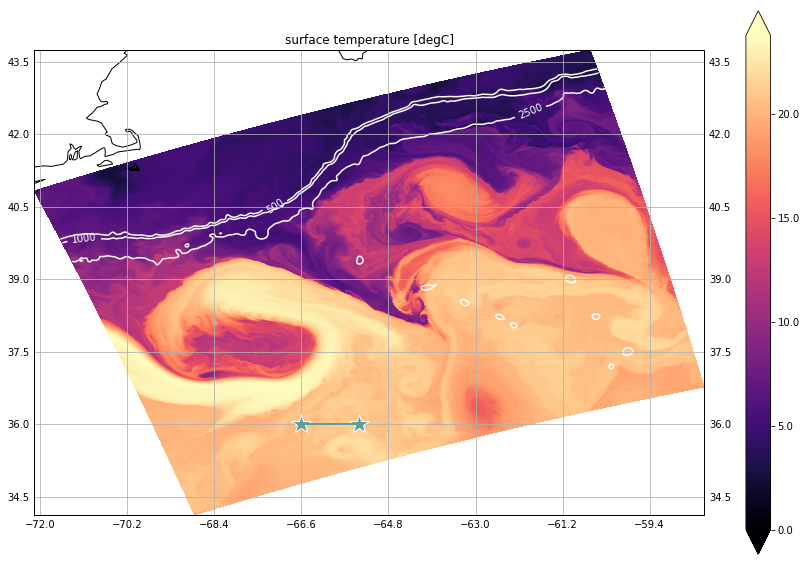

In [2]:
s = bellhop({'gs': {'datadir': '/home/datawork-lops-osi/jgula/NESED/', 'lon': [-66.6,-65.4], \
                    'lat': [36.,36.], 'plot_map': True, 'contour':True}}, zmax = 4900)

# SSP profiles

In [3]:
r = s.SSP['gs']['s']              # range (m)
depth = s.SSP['gs']['depth'][:]   # depth (m)
c = s.SSP['gs']['c']              # celerity (m/s)
print('Number of values for each profile :', c.shape[1])
print('Number of celerity profiles :', c.shape[0])
print('Maximum range : %.1fkm' %(np.max(r)/1000.))

Number of values for each profile : 50
Number of celerity profiles : 216
Maximum range : 107.8km


# Generate .env file (A)

- *Bathymetry* : flat bottom at 4500 m depth

- *Source* : one source at 100m depth at range 0km

- *Receivers* : **Depth : every 1m from 0 to 500m depth    /    Range : every 10m from 0 to 100 km **


In [4]:
# Generate .env file A
issp=0                                # sound speed profile number

s.params['hypothesis'] = 'QVWT'       # Q for quadrilateral SSP interpolation (SSP2D)
s.params['file_type'] = 'A'           # 'E' : eigen rays (.rau) / 'A' : arrivals time and amplitude file (.arr)
s.params['zs'] = 100.                 # source depth
s.params['ALimites'] = [-89.0, 89.0]  # limit angles

s.params['NDepth'] = 51               # number of receiver depths
s.params['zmin'] = 0.                 # minimum depth (m)
s.params['zmax'] = 500.               # maximum depth (m) (unuseful if NDepth=1)
                 
s.params['NRange'] = 101              # number of receiver range    
s.params['rmin'] = 0.                 # minimum range (km)
s.params['rmax'] = 100.               # maximum range (km) (unuseful if NRange=1)            

s.params['zbox'] = 5000.              # box depth limit 
s.params['rbox'] = 101.               # box range limit 

s.generate_envfile('gs',file_env = 'gs_2D_A.env', Issp=issp, SSP_depth_step=1)

# Generate .ssp file

In [5]:
s.generate_sspfile('gs', file_env='gs_2D_A.env', SSP_depth_step=1)

Output file is : gs_2D_A.ssp


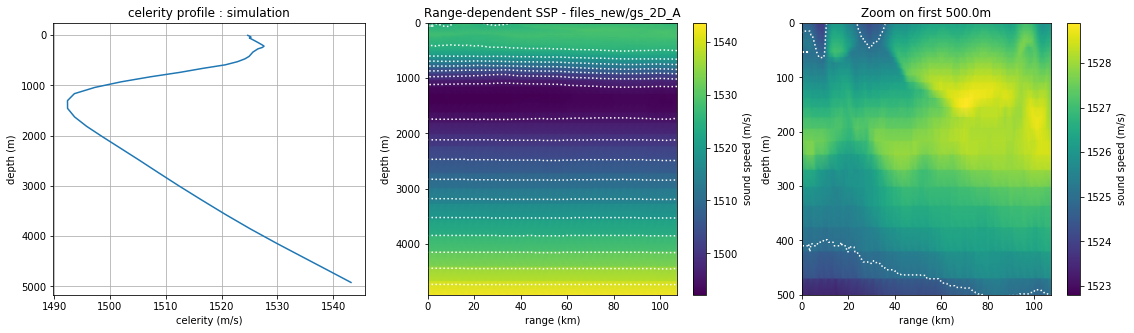

In [6]:
plt.figure(figsize=(19,5))
plt.subplot(131)
s.plotssp ('gs', Issp=0, zoom=False)
plt.subplot(132)
s.plotssp2D('files_new/gs_2D_A.ssp')
plt.subplot(133)
s.plotssp2D('files_new/gs_2D_A.ssp', zoom = 550.)
plt.show()

In [7]:
Temp = np.flipud(s.SSP['gs']['Temp'])
Sal = np.flipud(s.SSP['gs']['Sal'])

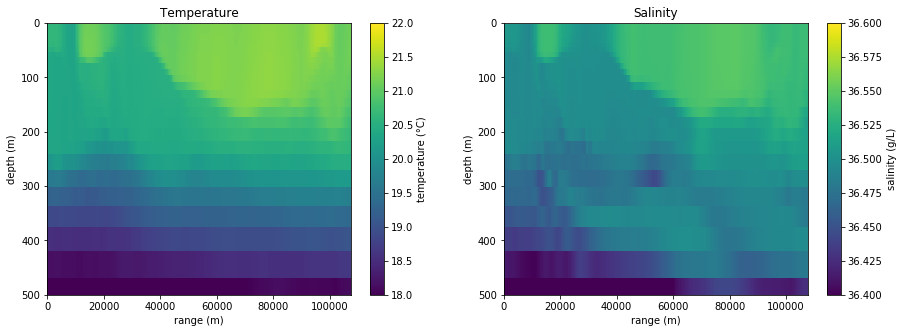

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.pcolormesh(r, depth, Temp)
plt.title ('Temperature')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("temperature (°C)")
plt.ylim([0,500])
plt.clim([18.,22.])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.pcolormesh(r, depth, Sal)
plt.title ('Salinity')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("salinity (g/L)")
plt.ylim([0,500])
plt.clim([36.4,36.6])
plt.gca().invert_yaxis()
plt.show()

---
# Arrival calculations

In [9]:
### read file .arr 
Arr, Pos = s.read_arrivals_asc ('files_new/gs_2D_A.arr', Narrmx = 435)
#s.save_dict('../Dictio', Arr, 'Arr_gs_SSP2D')
#s.save_dict('../Dictio', Pos, 'Pos_gs_SSP2D')
#Arr, Pos = s.load_dict('../Dictio', 'Arr_gs_SSP2D'), s.load_dict('../Dictio', 'Pos_gs_SSP2D')

Max.number of arrivals for source index 0 is 434


In [10]:
Nsd = np.shape(Pos['s']['depth'])[0]
Nrd = np.shape(Pos['r']['depth'])[0]
Nrr = np.shape(Pos['r']['range'])[0]

print('Number of source depths   : Nsd = ', Nsd)
print('Number of receiver depths : Nrd = ', Nrd)
print('Number of receiver ranges : Nrr = ', Nrr)

print ('\nTotal number of receivers : ', Nrr*Nrd)

Number of source depths   : Nsd =  1
Number of receiver depths : Nrd =  51
Number of receiver ranges : Nrr =  101

Total number of receivers :  5151


---
# Arrival times tables 

In [11]:
### sonar equation
SL = 185                 # Souce level (dB)
NL = 81.7                # Noise level (dB)
DI = 0                   # Directivity index (dB)
B = 200                  # bandwidth (Hz)
T = 1                    # transmitted signal duration (s)
PG = 10.0*np.log10(B*T)  # Processing gain (dB)

#RT  = SL - TL - NL + DI + PG 
seuil_d = 10.

In [12]:
# Create time table from bellhop output data. Based on detection treshold method.
def time_table (Arr) :
    T = np.zeros( (Nrr, Nrd, Nsd) )
    for isd1 in range (Nsd):
        for ird1 in range (Nrd) : 
            for irr1 in range (Nrr) :
                Narr = int(Arr['Narr'][irr1, ird1, isd1])
                if not Narr ==0 :
                    A = abs(Arr['A'][irr1, :Narr, ird1, isd1])  # amplitude 
                    TL = - 20.0*np.log10(A)
                    RL = SL - TL - NL +DI + PG    # received level 
                    t = Arr['delay'][irr1, :Narr, ird1, isd1]
                    t_ok = t[np.where(RL > seuil_d)]

                    if len(t_ok > 0): 
                        t_min = np.min(t_ok)
                        T[irr1,ird1,isd1] = t_min  
                    else : 
                        T[irr1,ird1,isd1] = np.NaN
                else : 
                    T[irr1,ird1,isd1] = np.NaN
    return (T)

---
### 1 - True arrival times

In [14]:
T_true = time_table(Arr)

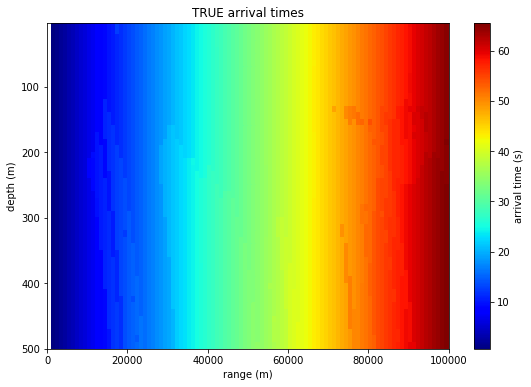

In [15]:
isd = 0    # source number (only 1 source here)
R = Pos['r']['range']
Z = Pos['r']['depth']
plt.figure(figsize=(9,6))
plt.pcolormesh(R, Z, T_true[:,:,isd].T, cmap='jet')
plt.title ('TRUE arrival times')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("arrival time (s)")
plt.gca().invert_yaxis()

---
### 2 - One profile (at range 50km) arrival times

In [16]:
### Generate .env file A
s.params['hypothesis'] = 'SVWT' 
s.generate_envfile('gs',file_env = 'gs_1prof_A.env', Issp=issp, SSP_depth_step=1, c = c[100,:])

In [17]:
### read file .arr 
Arr_1prof, Pos_1prof = s.read_arrivals_asc ('files_new/gs_1prof_A.arr', Narrmx = 215)
#Arr_1prof, Pos_1prof = s.load_dict('../Dictio', 'Arr_gs_1prof'), s.load_dict('../Dictio', 'Pos_gs_1prof')

Max.number of arrivals for source index 0 is 214


In [18]:
T_1prof = time_table(Arr_1prof)
#np.save('T_1prof', T_1prof)
#T_1prof = np.load('NPY_2D/T_1prof.npy')

---
# Comparison and error on distance 

In [19]:
diff_1prof = T_true - T_1prof
celerity = 1500. 
dx = diff_1prof * celerity

dx < 10m : 13.3%
10m < dx < 50m : 19.2%
dx > 50m : 66.5%


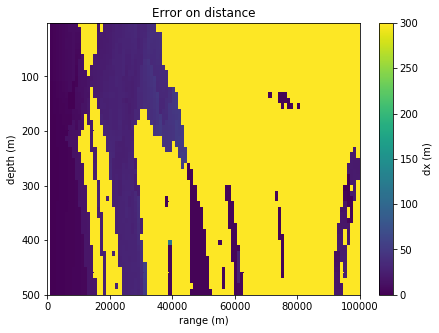

In [20]:
# dx table
plt.figure(figsize=(7,5))
plt.pcolormesh(R, Z, abs(dx[:,:,isd]).T) #, cmap='jet')
plt.title ('Error on distance')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dx (m)")
plt.clim([0,300])
plt.gca().invert_yaxis()

# Pourcents
tot = dx.shape[0]*dx.shape[1]
under10 = np.where(abs(dx) <10.)[0].shape[0]
under50 = np.where(np.logical_and(abs(dx) >=10., abs(dx) < 50.))[0].shape[0]
over50  = np.where(abs(dx) >= 50.)[0].shape[0]
print ('dx < 10m : %.1f' %(under10/tot*100.) + '%')
print ('10m < dx < 50m : %.1f' %(under50/tot*100.) + '%')
print ('dx > 50m : %.1f' %(over50/tot*100.) + '%')


---
### Ray comparison 

In [21]:
# TRUE : Generate .env and .ssp file R
s.params['NBeams'] = 20
s.params['hypothesis'] = 'QVWT'       # Q for quadrilateral SSP interpolation (SSP2D)
s.params['file_type'] = 'R'
s.params['ALimites'] = [-7,7]
s.generate_envfile('gs',file_env = 'gs_2D_R.env', Issp=issp, SSP_depth_step=1)
s.generate_sspfile('gs', file_env='gs_2D_R.env', SSP_depth_step=1)

### 1profile : Generate .env file R
s.params['hypothesis'] = 'SVWT' 
s.generate_envfile('gs',file_env = 'gs_1prof_R.env', Issp=issp, SSP_depth_step=1, c = c[100,:])

Output file is : gs_2D_R.ssp


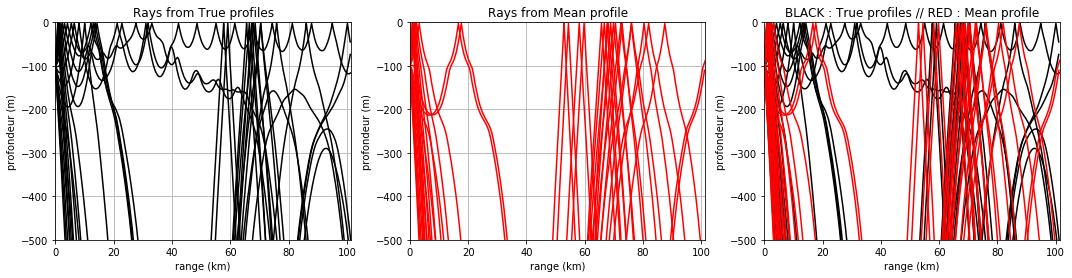

In [22]:
plt.figure(figsize=(18,4))
plt.subplot(131)
s.plotray('files_2D/gs_2D_R.ray', colors='k', zoom=True)
plt.title('Rays from True profiles')
plt.subplot(132)
s.plotray('files_2D/gs_1prof_R.ray', colors='r', zoom=True)
plt.title('Rays from Mean profile')
plt.subplot(133)
s.plotray('files_2D/gs_2D_R.ray', colors='k', zoom=True)
s.plotray('files_2D/gs_1prof_R.ray', colors='r', zoom=True)
plt.title('BLACK : True profiles // RED : Mean profile')
plt.show()

---
# With 3 profiles (one every 50km)

In [23]:
# ranges 0km, 50km and 107km 
c_3profiles = np.vstack((c[0,:],c[100,:],c[215,:]))
r_3profiles = np.array([r[0], r[100], r[215]]) 

In [24]:
# Generate .env file A and .ssp file
s.params['hypothesis'] = 'QVWT'
s.generate_envfile('gs',file_env = 'gs_2D_A_3prof.env', Issp=issp, SSP_depth_step=1, c = c_3profiles[0,:])
s.generate_sspfile('gs', file_env='gs_2D_A_3prof.env', SSP_depth_step=1, r = r_3profiles, c = c_3profiles)

Output file is : gs_2D_A_3prof.ssp


In [25]:
### read file .arr 
Arr_3prof, Pos_3prof = s.read_arrivals_asc ('files_new/gs_2D_A_3prof.arr', Narrmx = 68)
#Arr_3prof, Pos_3prof = s.load_dict('../Dictio', 'Arr_gs_3prof'), s.load_dict('../Dictio', 'Pos_gs_3prof')

Max.number of arrivals for source index 0 is 67


In [26]:
T_3prof = time_table(Arr_3prof)
#np.save('T_3prof', T_3prof)
#T_3prof = np.load('NPY_2D/T_3prof.npy')

In [27]:
diff_T2 = T_true - T_3prof
dx2 = diff_T2 * celerity

dx < 10m : 42.4%
10m < dx < 50m : 16.8%
dx > 50m : 39.8%


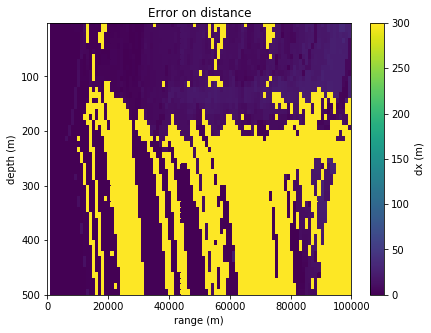

In [28]:
# dx table
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.pcolormesh(R, Z, abs(dx2[:,:,isd]).T) #, cmap='jet')
plt.title ('Error on distance')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dx (m)")
plt.clim([0,300])
plt.gca().invert_yaxis()

# Pourcents
tot = dx2.shape[0]*dx2.shape[1]
under10 = np.where(abs(dx2) <10.)[0].shape[0]
under50 = np.where(np.logical_and(abs(dx2) >=10., abs(dx2) < 50.))[0].shape[0]
over50  = np.where(abs(dx2) >= 50.)[0].shape[0]
print ('dx < 10m : %.1f' %(under10/tot*100.) + '%')
print ('10m < dx < 50m : %.1f' %(under50/tot*100.) + '%')
print ('dx > 50m : %.1f' %(over50/tot*100.) + '%')

### Ray comparison

In [29]:
# 3 PROFILES : Generate .env and .ssp file R
s.params['NBeams'] = 20
s.params['hypothesis'] = 'QVWT'       # Q for quadrilateral SSP interpolation (SSP2D)
s.params['file_type'] = 'R'
s.params['ALimites'] = [-7,7]         # limit angles

s.generate_envfile('gs',file_env = 'gs_2D_R_3prof.env', Issp=issp, SSP_depth_step=1, c = c_3profiles[0,:])
s.generate_sspfile('gs', file_env='gs_2D_R_3prof.env', SSP_depth_step=1, r = r_3profiles, c = c_3profiles)

Output file is : gs_2D_R_3prof.ssp


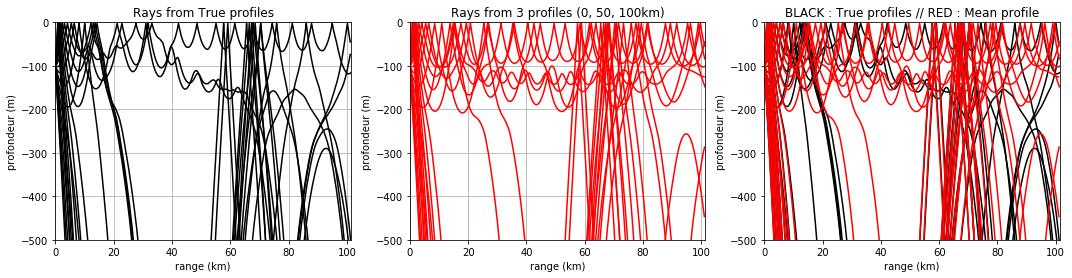

In [30]:
plt.figure(figsize=(18,4))
plt.subplot(131)
s.plotray('files_2D/gs_2D_R.ray', colors='k', zoom=True)
plt.title('Rays from True profiles')
plt.subplot(132)
s.plotray('files_2D/gs_2D_R_3prof.ray', colors='r', zoom=True)
plt.title('Rays from 3 profiles (0, 50, 100km)')
plt.subplot(133)
s.plotray('files_2D/gs_2D_R.ray', colors='k', zoom=True)
s.plotray('files_2D/gs_2D_R_3prof.ray', colors='r', zoom=True)
plt.title('BLACK : True profiles // RED : Mean profile')
plt.show()

---
# With 6 profiles(one every 20km)

In [31]:
# ranges 0km, 20km, 40km, 60km, 80km and 107km 
c_6profiles = np.vstack((c[0,:],c[41,:],c[81,:],c[121,:],c[161,:],c[215,:]))
r_6profiles = np.array([r[0], r[41],r[81],r[121],r[161], r[215]]) 

In [32]:
# Generate .env file A and .ssp file
s.params['hypothesis'] = 'QVWT'
s.generate_envfile('gs',file_env = 'gs_2D_A_6prof.env', Issp=issp, SSP_depth_step=1, c = c_6profiles[0,:])
s.generate_sspfile('gs', file_env='gs_2D_A_6prof.env', SSP_depth_step=1, r = r_6profiles, c = c_6profiles)

Output file is : gs_2D_A_6prof.ssp


In [33]:
### read file .arr 
Arr_6prof, Pos_6prof = s.read_arrivals_asc ('files_new/gs_2D_A_6prof.arr', Narrmx = 78)
T_6prof = time_table(Arr_6prof)

Max.number of arrivals for source index 0 is 77


In [34]:
diff_T6 = T_true - T_6prof
dx6 = diff_T6 * celerity

dx < 10m : 50.9%
10m < dx < 50m : 18.6%
dx > 50m : 29.5%


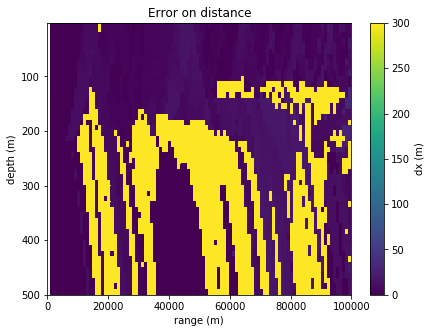

In [35]:
# dx table
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.pcolormesh(R, Z, abs(dx6[:,:,isd]).T) #, cmap='jet')
plt.title ('Error on distance')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dx (m)")
plt.clim([0,300])
plt.gca().invert_yaxis()

# Pourcents
tot = dx6.shape[0]*dx6.shape[1]
under10 = np.where(abs(dx6) <10.)[0].shape[0]
under50 = np.where(np.logical_and(abs(dx6) >=10., abs(dx6) < 50.))[0].shape[0]
over50  = np.where(abs(dx6) >= 50.)[0].shape[0]
print ('dx < 10m : %.1f' %(under10/tot*100.) + '%')
print ('10m < dx < 50m : %.1f' %(under50/tot*100.) + '%')
print ('dx > 50m : %.1f' %(over50/tot*100.) + '%')

### Ray comparison 

In [36]:
# 6 PROFILES : Generate .env and .ssp file R
s.params['NBeams'] = 20
s.params['hypothesis'] = 'QVWT'       # Q for quadrilateral SSP interpolation (SSP2D)
s.params['file_type'] = 'R'
s.params['ALimites'] = [-7,7]         # limit angles

s.generate_envfile('gs',file_env = 'gs_2D_R_6prof.env', Issp=issp, SSP_depth_step=1, c = c_6profiles[0,:])
s.generate_sspfile('gs', file_env='gs_2D_R_6prof.env', SSP_depth_step=1, r = r_6profiles, c = c_6profiles)

Output file is : gs_2D_R_6prof.ssp


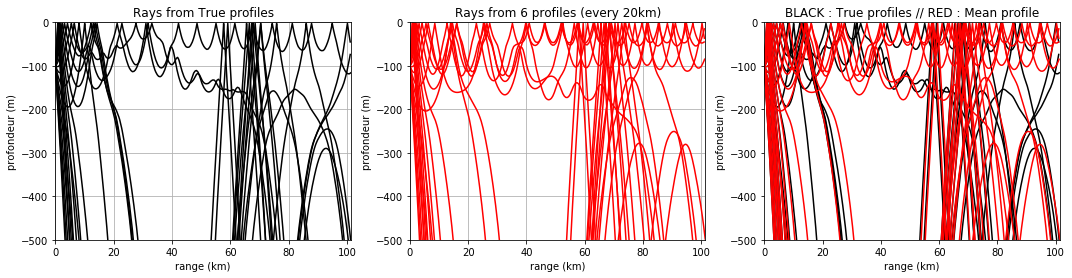

In [37]:
plt.figure(figsize=(18,4))
plt.subplot(131)
s.plotray('files_2D/gs_2D_R.ray', colors='k', zoom=True)
plt.title('Rays from True profiles')
plt.subplot(132)
s.plotray('files_2D/gs_2D_R_6prof.ray', colors='r', zoom=True)
plt.title('Rays from 6 profiles (every 20km)')
plt.subplot(133)
s.plotray('files_2D/gs_2D_R.ray', colors='k', zoom=True)
s.plotray('files_2D/gs_2D_R_6prof.ray', colors='r', zoom=True)
plt.title('BLACK : True profiles // RED : Mean profile')
plt.show()

# With 1 profile every 10 km

In [38]:
c_12profiles = np.vstack((c[0,:],c[20,:],c[40,:],c[60,:],c[80,:],c[100,:], \
                          c[120,:],c[140,:],c[160,:],c[180,:],c[200,:],c[215,:]))

r_12profiles = np.array([r[0], r[20], r[40], r[60], r[80], r[100], r[120], \
                         r[140], r[160], r[180], r[200], r[215]]) 

In [39]:
# Generate .env file A and .ssp file
s.params['hypothesis'] = 'QVWT'
s.generate_envfile('gs',file_env = 'gs_2D_A_12prof.env', Issp=issp, SSP_depth_step=1, c = c_12profiles[0,:])
s.generate_sspfile('gs', file_env='gs_2D_A_12prof.env', SSP_depth_step=1, r = r_12profiles, c = c_12profiles)

Output file is : gs_2D_A_12prof.ssp


In [40]:
### read file .arr 
Arr_12prof, Pos_12prof = s.read_arrivals_asc ('files_new/gs_2D_A_12prof.arr', Narrmx = 65)
T_12prof = time_table(Arr_12prof)

Max.number of arrivals for source index 0 is 64


In [41]:
diff_T12 = T_true - T_12prof
dx12 = diff_T12 * celerity

dx < 10m : 72.8%
10m < dx < 50m : 3.2%
dx > 50m : 23.0%


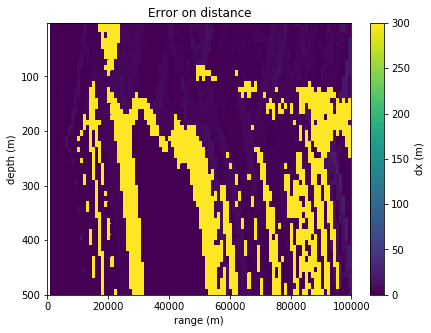

In [42]:
# dx table
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.pcolormesh(R, Z, abs(dx12[:,:,isd]).T) #, cmap='jet')
plt.title ('Error on distance')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dx (m)")
plt.clim([0,300])
plt.gca().invert_yaxis()

# Pourcents
tot = dx12.shape[0]*dx12.shape[1]
under10 = np.where(abs(dx12) <10.)[0].shape[0]
under50 = np.where(np.logical_and(abs(dx12) >=10., abs(dx12) < 50.))[0].shape[0]
over50  = np.where(abs(dx12) >= 50.)[0].shape[0]
print ('dx < 10m : %.1f' %(under10/tot*100.) + '%')
print ('10m < dx < 50m : %.1f' %(under50/tot*100.) + '%')
print ('dx > 50m : %.1f' %(over50/tot*100.) + '%')

In [43]:
np.mean(abs(dx12[~np.isnan(dx12)]))

339.8981738129412

In [44]:
e_t = np.sqrt( np.mean( abs(dx12[~np.isnan(dx12)])**2 )) 
e_t

749.0592428936694

In [45]:
e_t = np.sqrt( np.mean( abs(dx6[~np.isnan(dx6)])**2 )) 
e_t

841.6466689811098

---
---
---
---
# Zone à grande variabilité (tourbillon)

1 grid file found, uses: /home/datawork-lops-osi/jgula/NESED/nesea_grd.nc
-- Grid object
dim lon_rho: 1602  2002
lon_rho min= -72.123, max=-58.273
lat_rho min= 34.123, max=43.734
h min= 20.000, max=5543.070
Uses the following output file: /home/datawork-lops-osi/jgula/NESED/nesed_avg.00060.nc
The transect will contain 234 horizontal points


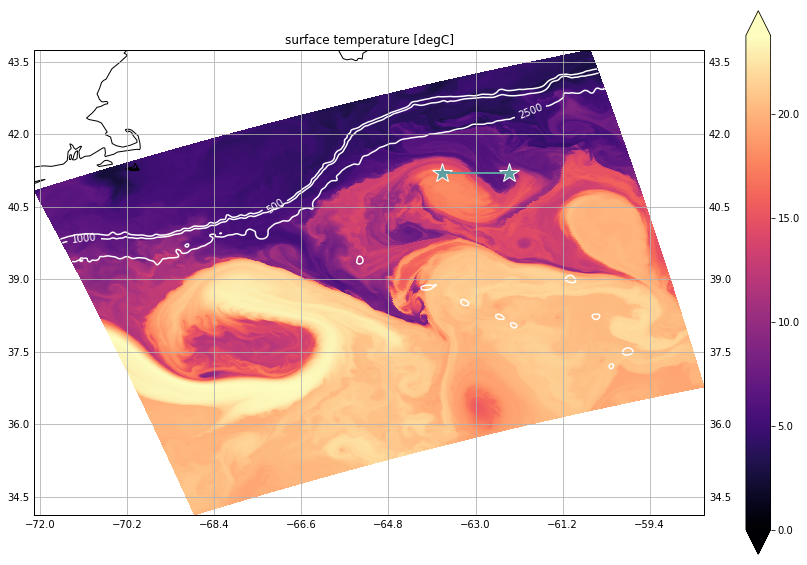

In [46]:
s1 = bellhop({'gs': {'datadir': '/home/datawork-lops-osi/jgula/NESED/', 'lon': [-63.7,-62.3], \
                    'lat': [41.2,41.2], 'plot_map': True, 'contour':True}}, zmax = 4900)

In [47]:
r1 = s1.SSP['gs']['s']              # range (m)
depth1 = s1.SSP['gs']['depth'][:]   # depth (m)
c1 = s1.SSP['gs']['c']              # celerity (m/s)
print('Number of values for each profile :', c1.shape[1])
print('Number of celerity profiles :', c1.shape[0])
print('Maximum range : %.1fkm' %(np.max(r1[:-1])/1000.))

Number of values for each profile : 50
Number of celerity profiles : 234
Maximum range : 116.4km


In [48]:
# Generate .env file A
issp=0                                # sound speed profile number

s1.params['hypothesis'] = 'QVWT'       # Q for quadrilateral SSP interpolation (SSP2D)
s1.params['file_type'] = 'A'           # 'E' : eigen rays (.rau) / 'A' : arrivals time and amplitude file (.arr)
s1.params['zs'] = 100.                 # source depth
s1.params['ALimites'] = [-89.0, 89.0]  # limit angles

s1.params['NDepth'] = 51               # number of receiver depths
s1.params['zmin'] = 0.                 # minimum depth (m)
s1.params['zmax'] = 500.               # maximum depth (m) (unuseful if NDepth=1)
                 
s1.params['NRange'] = 101              # number of receiver range    
s1.params['rmin'] = 0.                 # minimum range (km)
s1.params['rmax'] = 100.               # maximum range (km) (unuseful if NRange=1)            

s1.params['zbox'] = 5000.              # box depth limit 
s1.params['rbox'] = 101.               # box range limit 

s1.generate_envfile('gs',file_env = 'gs1_2D_A.env', Issp=issp, SSP_depth_step=1)

In [49]:
s1.generate_sspfile('gs', file_env='gs1_2D_A.env', SSP_depth_step=1)

Output file is : gs1_2D_A.ssp


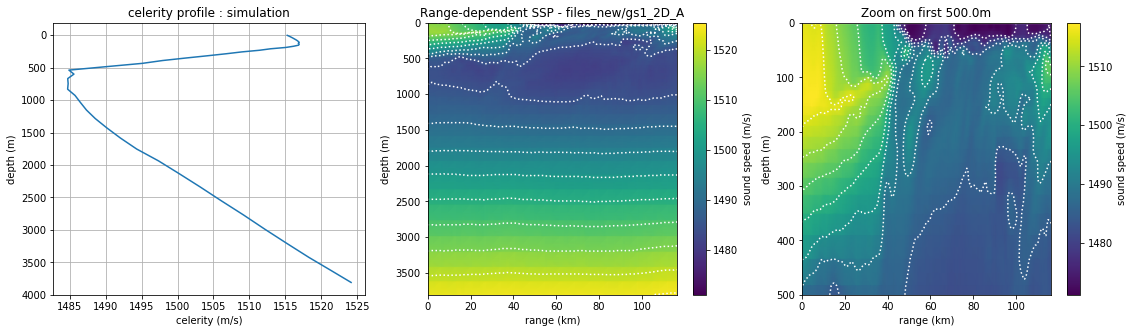

In [50]:
plt.figure(figsize=(19,5))
plt.subplot(131)
s1.plotssp ('gs', Issp=0, zoom=False)
plt.subplot(132)
s1.plotssp2D('files_new/gs1_2D_A.ssp')
plt.subplot(133)
s1.plotssp2D('files_new/gs1_2D_A.ssp', zoom = 550.)
plt.show()

In [51]:
Temp1 = np.flipud(s1.SSP['gs']['Temp'])
Sal1 = np.flipud(s1.SSP['gs']['Sal'])

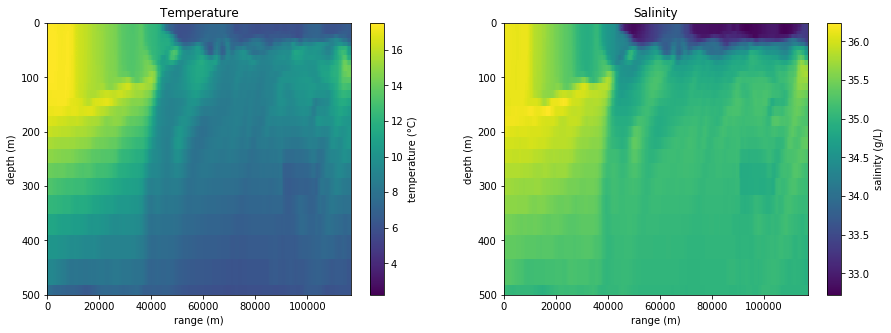

In [52]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.pcolormesh(r1, depth1, Temp1)
plt.title ('Temperature')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("temperature (°C)")
plt.ylim([0,500])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.pcolormesh(r1, depth1, Sal1)
plt.title ('Salinity')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("salinity (g/L)")
plt.ylim([0,500])
plt.gca().invert_yaxis()
plt.show()

In [53]:
### read file .arr 
Arr1, Pos1 = s1.read_arrivals_asc ('files_new/gs1_2D_A.arr', Narrmx = 203)
T_true1 = time_table(Arr1)

Max.number of arrivals for source index 0 is 202


---
---
## With one profile every 10 km 

In [54]:
c1_12profiles = np.vstack((c1[0,:],c1[20,:],c1[40,:],c1[60,:],c1[80,:],c1[100,:], \
                          c1[120,:],c1[140,:],c1[160,:],c1[180,:],c1[200,:],c1[215,:]))

r1_12profiles = np.array([r1[0], r1[20], r1[40], r1[60], r1[80], r1[100], r1[120], \
                         r1[140], r1[160], r1[180], r1[200], r1[215]]) 

In [55]:
# Generate .env file A and .ssp file
s1.params['hypothesis'] = 'QVWT'
s1.generate_envfile('gs',file_env = 'gs1_2D_A_12prof.env', Issp=issp, SSP_depth_step=1, c = c1_12profiles[0,:])
s1.generate_sspfile('gs', file_env='gs1_2D_A_12prof.env', SSP_depth_step=1, r = r1_12profiles, c = c1_12profiles)


Output file is : gs1_2D_A_12prof.ssp


In [57]:
Arr1_12prof, Pos1_12prof = s1.read_arrivals_asc ('files_new/gs1_2D_A_12prof.arr', Narrmx = 288)
T1_12prof = time_table(Arr1_12prof)

Max.number of arrivals for source index 0 is 287


In [58]:
diff1_12prof = T_true1 - T1_12prof
celerity = 1500. 
dx1_12 = diff1_12prof * celerity

dx < 10m : 58.0%
10m < dx < 50m : 10.3%
dx > 50m : 30.7%


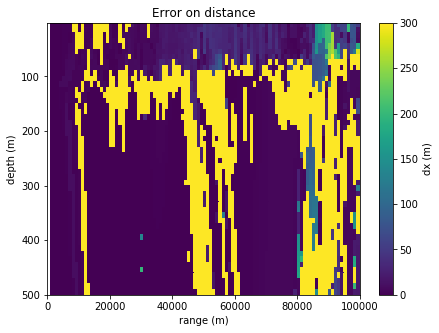

In [59]:
# dx table
plt.figure(figsize=(7,5))
plt.pcolormesh(R, Z, abs(dx1_12[:,:,isd]).T) #, cmap='jet')
plt.title ('Error on distance')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dx (m)")
plt.clim([0,300])
plt.gca().invert_yaxis()

# Pourcents
tot = dx1_12.shape[0]*dx1_12.shape[1]
under10 = np.where(abs(dx1_12) <10.)[0].shape[0]
under50 = np.where(np.logical_and(abs(dx1_12) >=10., abs(dx1_12) < 50.))[0].shape[0]
over50  = np.where(abs(dx1_12) >= 50.)[0].shape[0]
print ('dx < 10m : %.1f' %(under10/tot*100.) + '%')
print ('10m < dx < 50m : %.1f' %(under50/tot*100.) + '%')
print ('dx > 50m : %.1f' %(over50/tot*100.) + '%')

In [60]:
# TRUE : Generate .env and .ssp file R
s1.params['NBeams'] = 20
s1.params['hypothesis'] = 'QVWT'       # Q for quadrilateral SSP interpolation (SSP2D)
s1.params['file_type'] = 'R'
s1.params['ALimites'] = [-7,7]
s1.generate_envfile('gs',file_env = 'gs1_2D_R.env', Issp=issp, SSP_depth_step=1)
s1.generate_sspfile('gs', file_env='gs1_2D_R.env', SSP_depth_step=1)


Output file is : gs1_2D_R.ssp


In [61]:
# 12 PROFILES : Generate .env and .ssp file R
s1.params['NBeams'] = 20
s1.params['hypothesis'] = 'QVWT'       # Q for quadrilateral SSP interpolation (SSP2D)
s1.params['file_type'] = 'R'
s1.params['ALimites'] = [-7,7]         # limit angles

s1.generate_envfile('gs',file_env = 'gs1_2D_R_12prof.env', Issp=issp, SSP_depth_step=1, c = c1_12profiles[0,:])
s1.generate_sspfile('gs', file_env='gs1_2D_R_12prof.env', SSP_depth_step=1, r = r1_12profiles, c = c1_12profiles)

Output file is : gs1_2D_R_12prof.ssp


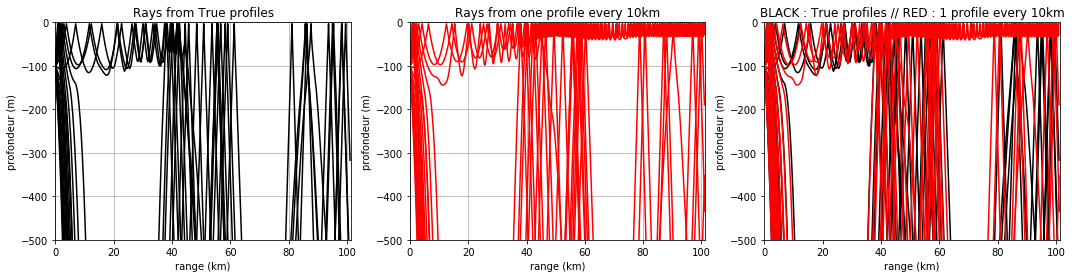

In [62]:
plt.figure(figsize=(18,4))
plt.subplot(131)
s.plotray('files_new/gs1_2D_R.ray', colors='k', zoom=True)
plt.title('Rays from True profiles')
plt.subplot(132)
s.plotray('files_new/gs1_2D_R_12prof.ray', colors='r', zoom=True)
plt.title('Rays from one profile every 10km')
plt.subplot(133)
s.plotray('files_new/gs1_2D_R.ray', colors='k', zoom=True)
s.plotray('files_new/gs1_2D_R_12prof.ray', colors='r', zoom=True)
plt.title('BLACK : True profiles // RED : 1 profile every 10km')
plt.show()

---
---
---
---
---
# New region : Atlantic 

-- Grid object
dim lon_rho: 1602  2002
lon_rho min= -72.241, max=11.166
lat_rho min= 35.893, max=69.856
h min= 20.000, max=6094.148
Uses the following output file: /home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.00000.nc
The transect will contain 55 horizontal points


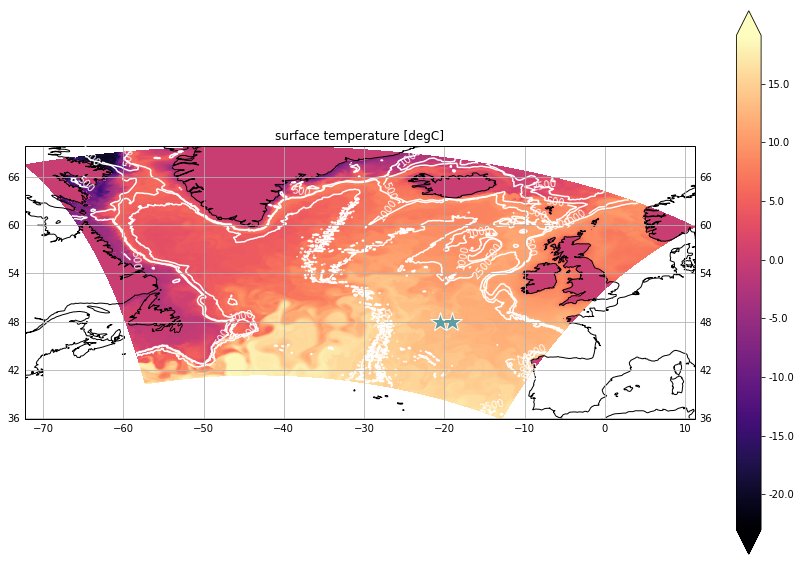

In [63]:
### atlantique nord

# sortie simu : /home/datawork-lops-osi/mlecorre/POLGYR/HIS/ 
# grille      : /home/datawork-lops-osi/jgula/POLGYR/polgyr_grd.nc

s3 = bellhop({'atl': {'data_files': '/home/datawork-lops-osi/mlecorre/POLGYR/HIS/*his*.nc', 
                     'hgrid_file': '/home/datawork-lops-osi/jgula/POLGYR/polgyr_grd.nc',
                     'vgrid_file': '/home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.03960.nc', 
                     'lon': [-20.5, -19.], 'lat': [48., 48.], 'plot_map': True, 'contour':True}}, zmax = 4900)

In [65]:
r3 = s3.SSP['atl']['s']              # range (m)
depth3 = s3.SSP['atl']['depth'][:]   # depth (m)
c3 = s3.SSP['atl']['c']              # celerity (m/s)
print('Number of values for each profile :', c3.shape[1])
print('Number of celerity profiles :', c3.shape[0])
print('Maximum range : %.1fkm' %(np.max(r3[:-1])/1000.))

Number of values for each profile : 80
Number of celerity profiles : 55
Maximum range : 109.4km


In [67]:
# Generate .env file A
issp=0                                # sound speed profile number

s3.params['hypothesis'] = 'QVWT'       # Q for quadrilateral SSP interpolation (SSP2D)
s3.params['file_type'] = 'A'           # 'E' : eigen rays (.rau) / 'A' : arrivals time and amplitude file (.arr)
s3.params['zs'] = 100.                 # source depth
s3.params['ALimites'] = [-89.0, 89.0]  # limit angles

s3.params['NDepth'] = 51               # number of receiver depths
s3.params['zmin'] = 0.                 # minimum depth (m)
s3.params['zmax'] = 500.               # maximum depth (m) (unuseful if NDepth=1)
                 
s3.params['NRange'] = 101              # number of receiver range    
s3.params['rmin'] = 0.                 # minimum range (km)
s3.params['rmax'] = 100.               # maximum range (km) (unuseful if NRange=1)            

s3.params['zbox'] = 5000.              # box depth limit 
s3.params['rbox'] = 101.               # box range limit 

s3.generate_envfile('atl',file_env = 'atl_2D_A.env', Issp=issp, SSP_depth_step=1)

In [68]:
s3.generate_sspfile('atl', file_env='atl_2D_A.env', SSP_depth_step=1)

Output file is : atl_2D_A.ssp


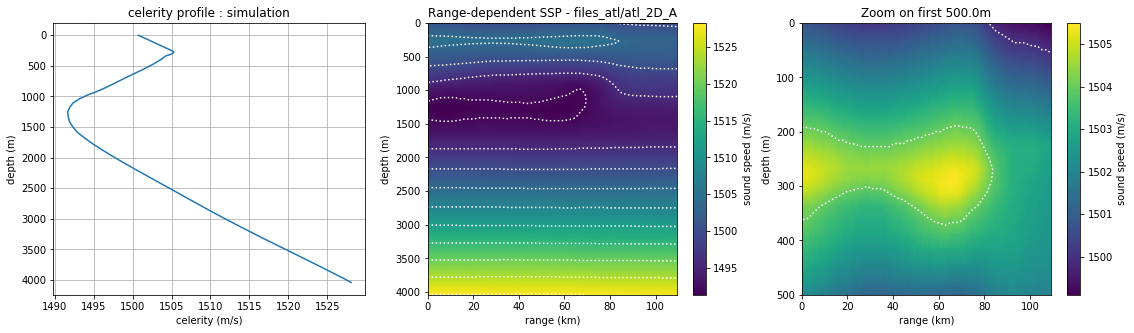

In [71]:
plt.figure(figsize=(19,5))
plt.subplot(131)
s3.plotssp ('atl', Issp=0, zoom=False)
plt.subplot(132)
s3.plotssp2D('files_atl/atl_2D_A.ssp')
plt.subplot(133)
s3.plotssp2D('files_atl/atl_2D_A.ssp', zoom = 550.)
plt.show()

In [72]:
Temp3 = np.flipud(s3.SSP['atl']['Temp'])
Sal3 = np.flipud(s3.SSP['atl']['Sal'])

In [75]:
### read file .arr 
Arr3, Pos3 = s3.read_arrivals_asc ('files_atl/atl_2D_A.arr', Narrmx = 79)
T_true3 = time_table(Arr3)

Max.number of arrivals for source index 0 is 78


## With 1 profile every 10km

In [79]:
c3_12profiles = np.vstack((c3[0,:],c3[5,:],c3[10,:],c3[15,:],c3[20,:],c3[25,:], \
                          c3[30,:],c3[35,:],c3[40,:],c3[45,:],c3[50,:],c3[54,:]))

r3_12profiles = np.array([r3[0], r3[5], r3[10], r3[15], r3[20], r3[25], r3[30], \
                         r3[35], r3[40], r3[45], r3[50], r3[55]]) 

In [80]:
# Generate .env file A and .ssp file
s3.params['hypothesis'] = 'QVWT'
s3.generate_envfile('atl',file_env = 'atl_2D_A_12prof.env', Issp=issp, SSP_depth_step=1, c = c3_12profiles[0,:])
s3.generate_sspfile('atl', file_env='atl_2D_A_12prof.env', SSP_depth_step=1, r = r3_12profiles, c = c3_12profiles)


Output file is : atl_2D_A_12prof.ssp


In [82]:
Arr3_12prof, Pos3_12prof = s3.read_arrivals_asc ('files_atl/atl_2D_A_12prof.arr', Narrmx = 54)
T3_12prof = time_table(Arr3_12prof)

Max.number of arrivals for source index 0 is 53


In [83]:
diff3_12prof = T_true3 - T3_12prof
celerity = 1500. 
dx3_12 = diff3_12prof * celerity

dx < 10m : 73.1%
10m < dx < 50m : 13.5%
dx > 50m : 12.4%


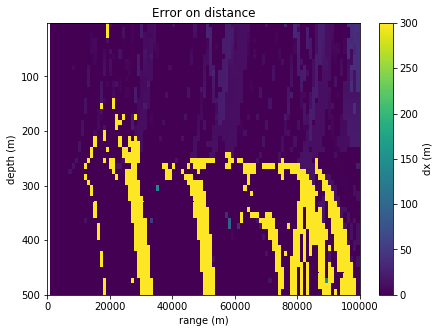

In [84]:
# dx table
plt.figure(figsize=(7,5))
plt.pcolormesh(R, Z, abs(dx3_12[:,:,isd]).T) #, cmap='jet')
plt.title ('Error on distance')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dx (m)")
plt.clim([0,300])
plt.gca().invert_yaxis()

# Pourcents
tot = dx3_12.shape[0]*dx3_12.shape[1]
under10 = np.where(abs(dx3_12) <10.)[0].shape[0]
under50 = np.where(np.logical_and(abs(dx3_12) >=10., abs(dx3_12) < 50.))[0].shape[0]
over50  = np.where(abs(dx3_12) >= 50.)[0].shape[0]
print ('dx < 10m : %.1f' %(under10/tot*100.) + '%')
print ('10m < dx < 50m : %.1f' %(under50/tot*100.) + '%')
print ('dx > 50m : %.1f' %(over50/tot*100.) + '%')

In [85]:
# TRUE : Generate .env and .ssp file R
s3.params['NBeams'] = 20
s3.params['hypothesis'] = 'QVWT'       # Q for quadrilateral SSP interpolation (SSP2D)
s3.params['file_type'] = 'R'
s3.params['ALimites'] = [-7,7]
s3.generate_envfile('atl',file_env = 'atl_2D_R.env', Issp=issp, SSP_depth_step=1)
s3.generate_sspfile('atl', file_env='atl_2D_R.env', SSP_depth_step=1)


Output file is : atl_2D_R.ssp


In [86]:
# 12 PROFILES : Generate .env and .ssp file R
s3.params['NBeams'] = 20
s3.params['hypothesis'] = 'QVWT'       # Q for quadrilateral SSP interpolation (SSP2D)
s3.params['file_type'] = 'R'
s3.params['ALimites'] = [-7,7]         # limit angles

s3.generate_envfile('atl',file_env = 'atl_2D_R_12prof.env', Issp=issp, SSP_depth_step=1, c = c3_12profiles[0,:])
s3.generate_sspfile('atl', file_env='atl_2D_R_12prof.env', SSP_depth_step=1, r = r3_12profiles, c = c3_12profiles)

Output file is : atl_2D_R_12prof.ssp


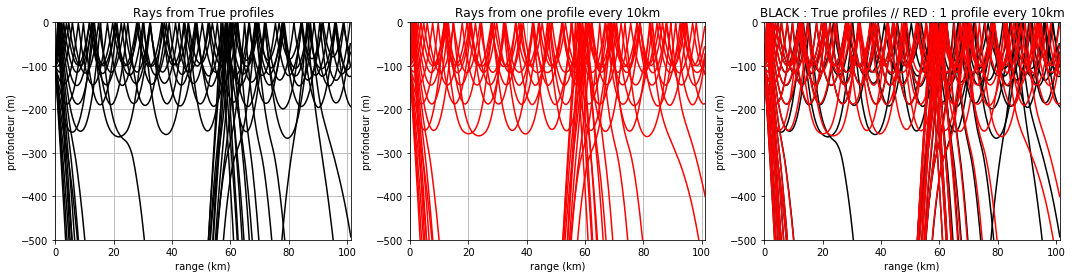

In [88]:
plt.figure(figsize=(18,4))
plt.subplot(131)
s.plotray('files_atl/atl_2D_R.ray', colors='k', zoom=True)
plt.title('Rays from True profiles')
plt.subplot(132)
s.plotray('files_atl/atl_2D_R_12prof.ray', colors='r', zoom=True)
plt.title('Rays from one profile every 10km')
plt.subplot(133)
s.plotray('files_atl/atl_2D_R.ray', colors='k', zoom=True)
s.plotray('files_atl/atl_2D_R_12prof.ray', colors='r', zoom=True)
plt.title('BLACK : True profiles // RED : 1 profile every 10km')
plt.show()